In [113]:
import numpy as np
np.set_printoptions(precision=3)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
optimizer = tf.keras.optimizers.Adam(learning_rate=0.5)

In [162]:
def K(X1,X2):
    return 100*np.exp(-np.sum(np.subtract(X1[:,None],X2[None,:])**2/(2*1**2),2))

In [167]:
X = tf.Variable(np.linspace(0,10,1000)[:,None],dtype=tf.float32)
Z = tf.Variable(np.linspace(0,10,10)[:,None],dtype=tf.float32)
y = tf.Variable(np.linspace(0,10,1000)+np.random.randn(1000),dtype=tf.float32)

m = Z.shape[0]

#definition of q(u)
mu = tf.Variable(tf.random.normal([m]))#, name='mu')
scale = tf.Variable(tf.random.normal([m, m]))#, name='scale')

#parameters for p(u)
mu_u = tf.zeros([1,m])
cov_u = tf.Variable(K(Z,Z))
pu = tfd.MultivariateNormalFullCovariance(mu_u,cov_u+np.eye(cov_u.shape[0])*0.01)
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)
for it in range(100):
    with tf.GradientTape() as tape:
        qu = tfd.MultivariateNormalTriL(mu,scale)
        
        qf_mu = K(X,Z) @ invKzz @ mu[:,None]
        #need to solve in a numerically stable manner.
        #only need trace of this... TODO
        qf_cov = K(X,X) - K(X,Z) @ invKzz @ K(Z,X) + K(X,Z)@ invKzz @(scale@tf.transpose(scale))@ invKzz @ K(Z,X)
        
        #py = tfd.MultivariateNormalDiag(qf_mu[:,0],np.ones(X.shape[0],dtype=np.float32))
        #ell = py.log_prob(y) - 0.5* tf.linalg.trace(qf_cov) ###Next thing is to try approximating this -> then replace with our complicated likelihood!
        
        alt_ell=0
        for i in range(X.shape[0]):
            alt_ell+=tfd.Normal(qf_mu[i,0],1).log_prob(y[i])-0.5*qf_cov[i,i]
        ell=alt_ell #quicker
        #print(ell.numpy(),alt_ell)
        #ell = logp     
        
        #Approximate ell:
        #ellapprx = 0
        #for i in range(X.shape[0]):
        #    dist_f = tfd.Normal(qf_mu[i,0],np.sqrt(qf_cov[i,i]))
        #    f = dist_f.sample(3000)
        #    ellapprx+=np.mean(tfd.Normal(f,1.0).log_prob(y[i]))
        #print(ell.numpy(), ellapprx)
        
        elbo_loss = -( ell - tfd.kl_divergence(qu,pu) )
    gradients = tape.gradient(elbo_loss, [mu, scale])
    optimizer.apply_gradients(zip(gradients, [mu, scale]))
    if it%5 == 0: print(it,elbo_loss.numpy())#,qf_mu[:,0].numpy(),mu.numpy())

0 [23645.314]
5 [4708.907]
10 [6731.085]
15 [3085.637]
20 [3447.296]
25 [2488.78]
30 [2649.656]
35 [2163.649]
40 [2130.348]
45 [3164.74]
50 [4330.052]
55 [4496.492]
60 [3997.03]
65 [3125.642]
70 [2576.153]
75 [2089.973]


KeyboardInterrupt: 

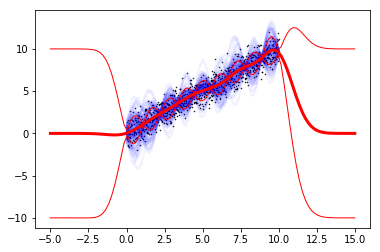

In [168]:
qf = tfd.MultivariateNormalFullCovariance(qf_mu[:,0],qf_cov+np.eye(qf_cov.shape[0])*0.01)
samps = qf.sample([100]).numpy()
plt.plot(X.numpy()[:,0],y.numpy(),'.k',markersize=1)
plt.plot(X.numpy()[:,0],samps.T,'b-',alpha=0.05);
Xstar = np.linspace(-5,15,100)[:,None]
invKzz = tf.linalg.inv(K(Z,Z)+np.eye(Z.shape[0],dtype=np.float32)*0.01)

mean = (K(Xstar,Z) @ invKzz @ mu.numpy()[:,None]).numpy()[:,0]
cov = K(Xstar,Xstar) - K(Xstar,Z) @ np.linalg.inv(K(Z,Z)) @ K(Z,Xstar)
stds = np.sqrt(np.diag(cov))

plt.plot(Xstar,mean,'r-',lw=3);
plt.plot(Xstar,mean+stds,'r-',lw=1);
plt.plot(Xstar,mean-stds,'r-',lw=1);